In [1]:
import sys
import importlib
from skimage.segmentation import chan_vese, slic, mark_boundaries
from skimage.color import label2rgb
sys.path.append('/Users/elliottunstall/Desktop/Imperial/FYP/codebase/utils')
from plotters import *
from useful_functions import *; from segmentation_toolkit import *
importlib.reload(sys.modules['useful_functions']); importlib.reload(sys.modules['segmentation_toolkit'])
from useful_functions import *; from segmentation_toolkit import *

import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from skimage.measure import label, regionprops
from matplotlib.patches import Rectangle as drawrect

In [2]:
path = '/Users/elliottunstall/Desktop/Imperial/FYP/Clinical BMode heart acquisitions/12_Clinical_20230421_114731_VERASONICS_HFR016_BMode_IM_0197.avi' # change path 
cap = cv2.VideoCapture(path)

data = np.zeros([600,800,3,36])
i = 0
while cap.isOpened():
    ret, frame = cap.read()  
    if ret:
        data[:,:,:,i] = frame
        i += 1
    else:
        break

    # Break the loop if the 'q' key is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):

            # Release the video capture object and close all windows
        cap.release()
        cv2.destroyAllWindows()
            
        break


image = np.asarray(data[:,:,0,9])
print(np.shape(image))

(600, 800)


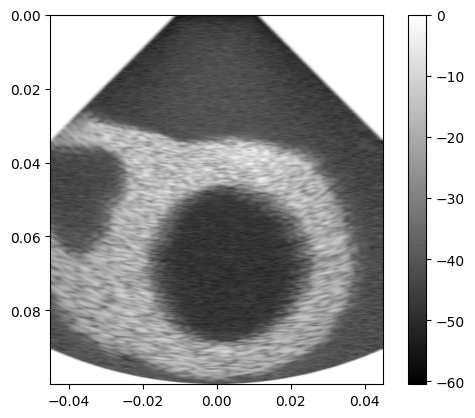

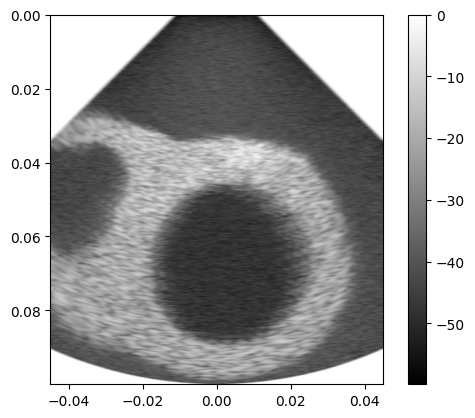

In [3]:
fixed, moving, pxm = load_inputs(10)
show_image(fixed, pxm)
show_image(moving, pxm)

Text(0.5, 1.0, 'Fig. 3. Histogram of intensities')

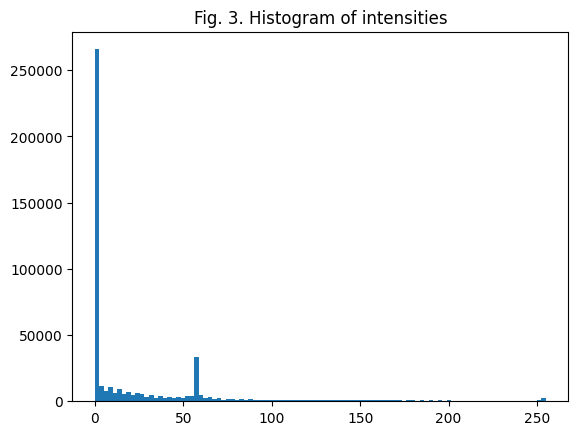

In [4]:
h, bin_edges = np.histogram(image, bins=100)
# by default, plt.bar is dumb: all bars have a width 0f 0.8! Phht....
barw = bin_edges[1]-bin_edges[0] # Should be the same for all bins.

plt.bar(bin_edges[:-1], h, width=barw, align='edge') # ...set bar width properly.
plt.title('Fig. 3. Histogram of intensities')


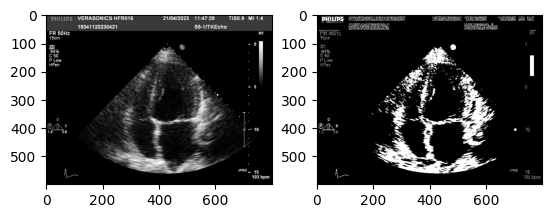

In [5]:
threshold_mask = np.logical_and(image > 60, image < 200)
plt.subplot(1,2,1)
plt.imshow(image, cmap='grey')
plt.subplot(1,2,2)
plt.imshow(threshold_mask, cmap='grey')

Text(0.5, 1.0, 'Connected Components Labelling')

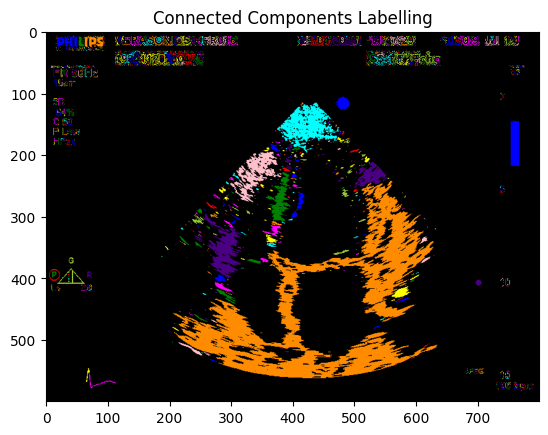

In [6]:
P_L = label(threshold_mask)
plt.imshow(label2rgb(P_L, bg_label=0))
plt.title('Connected Components Labelling')

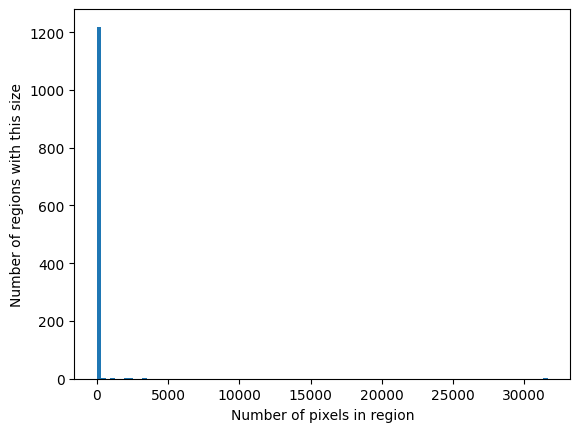

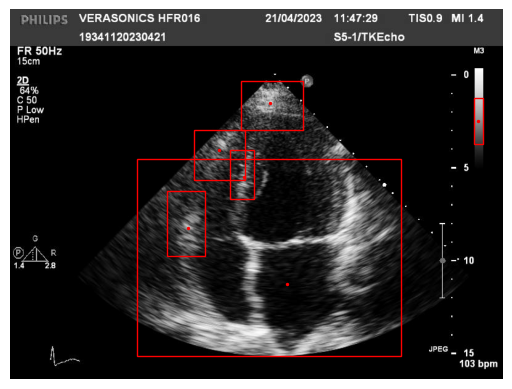

In [7]:
Regions = regionprops(P_L)
BBs = [thisRegion.bbox for thisRegion in Regions]
Areas = [thisRegion.area for thisRegion in Regions]

# I am taking the lazy option here! Compare with
# previous use of np.hist. 
HistogramOfPeaSize = plt.hist(Areas, 100) 
plt.xlabel('Number of pixels in region')
plt.ylabel('Number of regions with this size')

ValidRegions = [region for region in Regions if 
                         (region.area>1000 and region.area<40000)]

BBs = [thisRegion.bbox for thisRegion in ValidRegions]
Areas = [thisRegion.area for thisRegion in ValidRegions]
Centroids = [thisRegion.centroid for thisRegion in ValidRegions]
fig, ax = plt.subplots()
ax.imshow(image, cmap='grey')
ax.axis('off')

# The zip thing is not needed, you can instead use # enumerate and grab the corresponding indexed
# value from each list, but this is more readable... for (bb,area,centroid) in zip(BBs,Areas,Centroids):
for (bb,area,centroid) in zip(BBs,Areas,Centroids):
    r = drawrect((float(bb[1]-1),float(bb[0]-1)),
        bb[3]-bb[1],bb[2]-bb[0],
        edgecolor='r', facecolor='none')
    ax.add_patch(r)
    plt.scatter(centroid[1]-1, centroid[0]-1, c='r', s=2)


Text(0.5, 1.0, 'Connected Components Labelling')

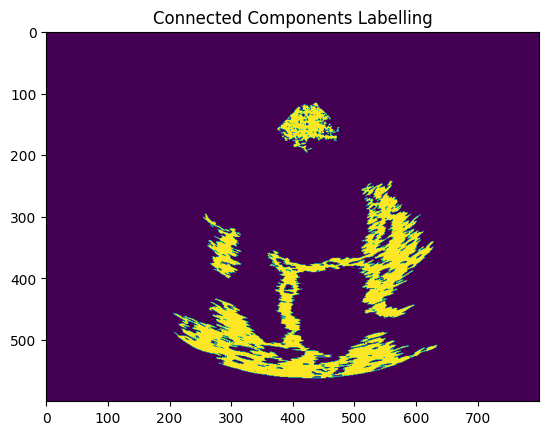

In [8]:
Areas = [thisRegion.area for thisRegion in Regions]

indexs = np.argsort(Areas)[::-1]
new_slice = np.zeros_like(threshold_mask)
for i in indexs[0:3]:
    new_slice[tuple(Regions[i].coords.T)] = i+1

plt.imshow(new_slice)
plt.title('Connected Components Labelling')

Text(0.5, 1.0, 'Connected Components Labelling')

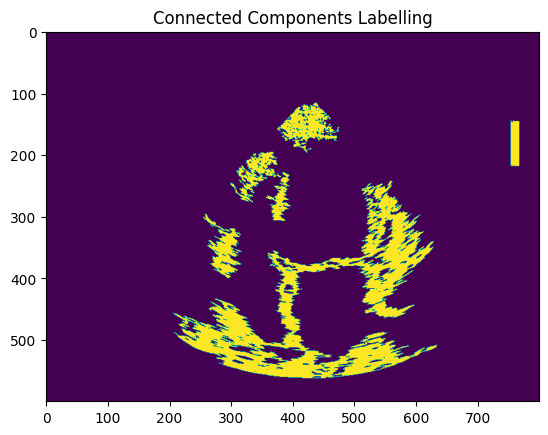

In [9]:
new_slice = np.zeros_like(threshold_mask)
for i in range(len(ValidRegions)):
    new_slice[tuple(ValidRegions[i].coords.T)] = i+1

plt.imshow(new_slice)
plt.title('Connected Components Labelling')

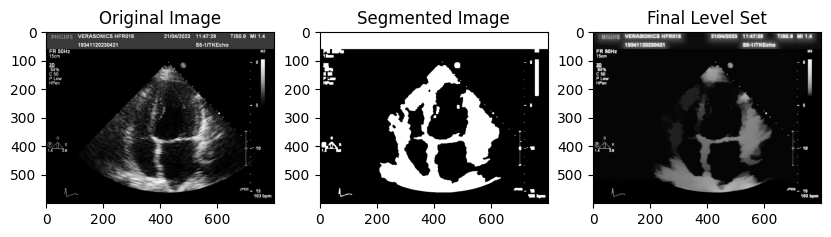

In [10]:
chanvese_image = chan_vese(np.asarray(data[:,:,0,9]), extended_output=True, lambda1 = 1.5, lambda2=2)

fig, axes = plt.subplots(1, 3, figsize=(10, 10))
ax = axes.flatten()

# Plotting the original image
ax[0].imshow(image, cmap="gray")
ax[0].set_title("Original Image")

# Plotting the segmented - 100 iterations image
ax[1].imshow(chanvese_image[0], cmap="gray")
ax[1].set_title("Segmented Image")

# Plotting the final level set
ax[2].imshow(chanvese_image[1], cmap="gray")
ax[2].set_title("Final Level Set")

plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


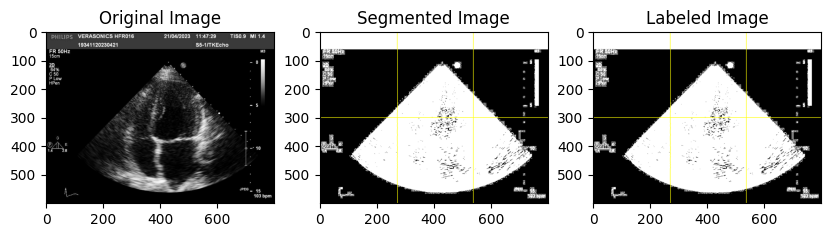

In [11]:
segments = slic(image, n_segments=5, compactness=100, channel_axis =None)
segmented_image = mark_boundaries(image, segments)
labeled_image = label2rgb(segments, image, kind = 'avg')

fig, axes = plt.subplots(1, 3, figsize=(10, 10))
ax = axes.flatten()

# Plotting the original image
ax[0].imshow(image, cmap="gray")
ax[0].set_title("Original Image")

# Plotting the segmented - 100 iterations image
ax[1].imshow(segmented_image)
ax[1].set_title("Segmented Image")

# Labeling image
ax[2].imshow(segmented_image)
ax[2].set_title("Labeled Image")

plt.show()

{'segmentation': ANTsImage
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (2952, 334)
	 Spacing    : (1.0, 1.0)
	 Origin     : (0.0, 0.0)
	 Direction  : [1. 0. 0. 1.]
, 'probabilityimages': [ANTsImage
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (2952, 334)
	 Spacing    : (1.0, 1.0)
	 Origin     : (0.0, 0.0)
	 Direction  : [1. 0. 0. 1.]
, ANTsImage
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (2952, 334)
	 Spacing    : (1.0, 1.0)
	 Origin     : (0.0, 0.0)
	 Direction  : [1. 0. 0. 1.]
, ANTsImage
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (2952, 334)
	 Spacing    : (1.0, 1.0)
	 Origin     : (0.0, 0.0)
	 Direction  : [1. 0. 0. 1.]
]}


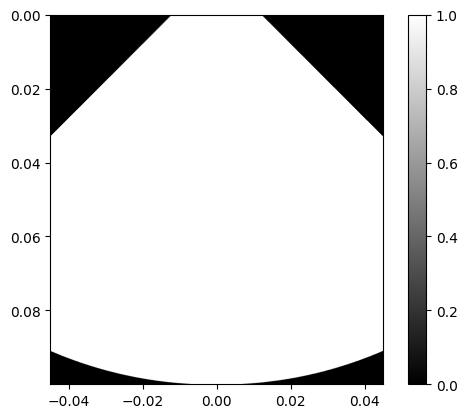

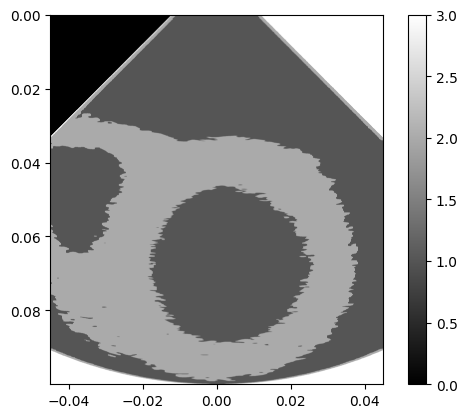

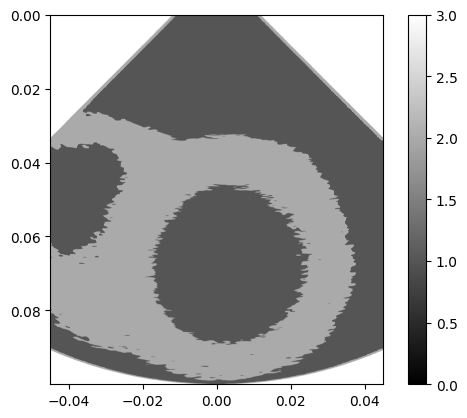

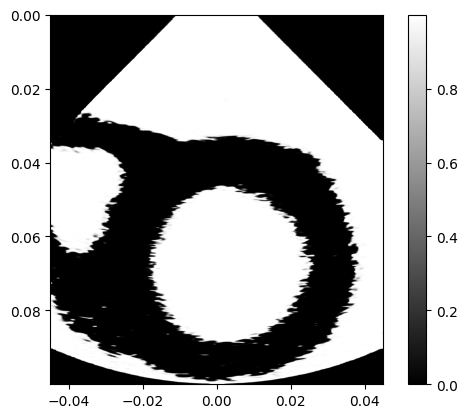

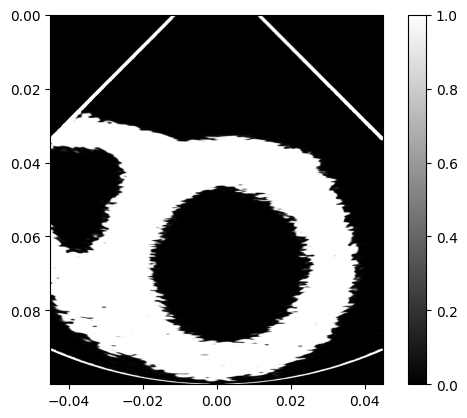

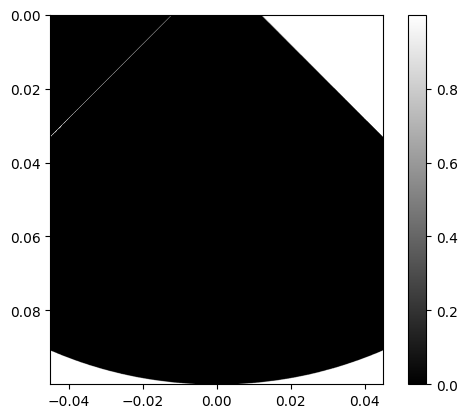

In [12]:
## ANTs methods

import ants

kmask = (fixed != 0).astype(float)
show_image(kmask, pxm)
kmask = ants.from_numpy(kmask)
ants_fixed = ants.from_numpy(fixed)
ants_moving = ants.from_numpy(moving)

seg_fixed = ants.kmeans_segmentation(ants_fixed, 3, kmask=kmask, mrf=0.2)
seg_moving = ants.kmeans_segmentation(ants_moving, 3, mrf=0.1)
print(seg_fixed)

show_image(seg_fixed['segmentation'].numpy(), pxm)
show_image(seg_moving['segmentation'].numpy(), pxm)
show_image(seg_fixed['probabilityimages'][0].numpy(), pxm)
show_image(seg_fixed['probabilityimages'][1].numpy(), pxm)
# plt.imshow(seg_fixed['probabilityimages'][1].numpy(), cmap='gray')
show_image(seg_fixed['probabilityimages'][2].numpy(), pxm)


In [13]:
from skimage.filters import threshold_otsu

threshold = threshold_otsu(fixed)
segmented_image = fixed > threshold

threshold = threshold_otsu(fixed)
segmented_background = fixed < threshold

# tissue_mask = segmented_image
# background_mask = segmented_background

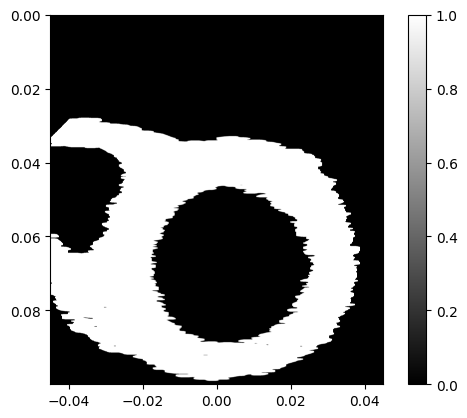

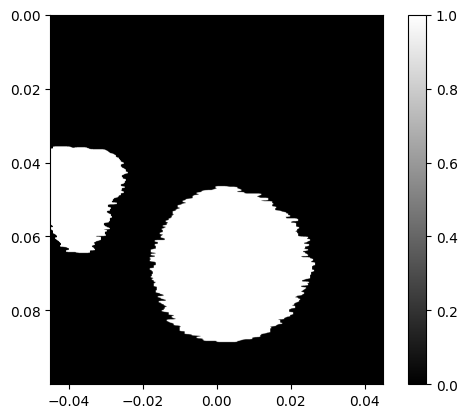

In [14]:
background_mask = seg_fixed['segmentation'].numpy() == 1
tissue_mask = seg_fixed['segmentation'].numpy() == 2

segmented_background = connected_components(background_mask)
segmented_tissue = connected_components(tissue_mask)
# print(segmented_tissue)
# show_image(segmented_background[1], pxm)

# tis_image = np.zeros_like(fixed); bac_image = np.zeros_like(fixed)
# for key, value in segmented_tissue.items():
#     tis_image += value
# kmask = (fixed == 0).astype(float)
tis_image = segmented_tissue[1]

# for key, value in segmented_background.items():
#     bac_image += value
bac_image = segmented_background[2] + segmented_background[3]

show_image(tis_image, pxm)
show_image(bac_image, pxm)
# plt.imshow(image, cmap='gray')

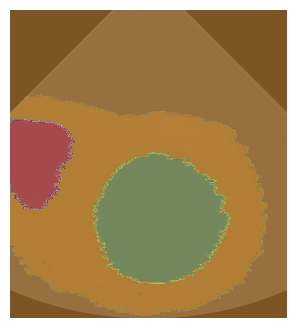

In [18]:

plot_image_and_mask(fixed, [segmented_tissue[1], segmented_background[2], segmented_background[3]], pixelMap = pxm)

In [17]:
COLORS = [(255,0,0),(255,255,0), (0,255,0)]

LABELS = [[0], [1], [1]] # 0 for bird, 1 for sheep

fixed = cv2.merge([fixed,fixed,fixed])
# gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# masks_list = [cv2.merge([i,i,i]) for i in [segmented_tissue[1], segmented_background[2], segmented_background[3]]]

masks_list = [segmented_tissue[1], segmented_background[2], segmented_background[3]]

segmented_image = draw_masks_fromList(fixed, masks_list, LABELS, COLORS)

cv2.imshow(segmented_image)

error: OpenCV(4.9.0) :-1: error: (-5:Bad argument) in function 'imshow'
> Overload resolution failed:
>  - imshow() missing required argument 'mat' (pos 2)
>  - imshow() missing required argument 'mat' (pos 2)
>  - imshow() missing required argument 'mat' (pos 2)
